# Определение возраста покупателей

## Исследовательский анализ данных

In [2]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [4]:
train_df = pd.read_csv('/datasets/faces/labels.csv')

In [5]:
train_df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


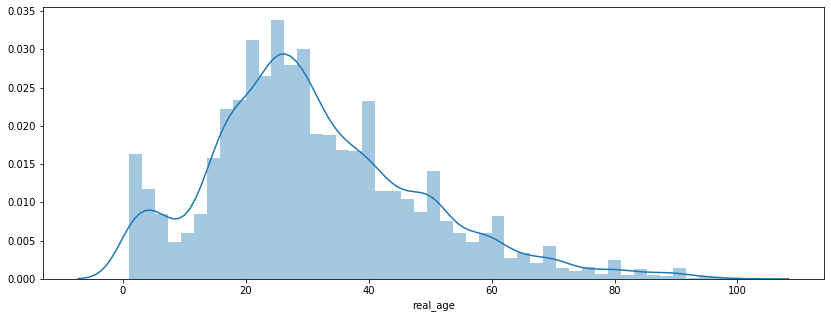

In [16]:
plt.figure(figsize=(14, 5))
sns.distplot(train_df['real_age']);

In [8]:
features, target = next(train_gen_flow)

In [9]:
array = np.array(features[0:16])

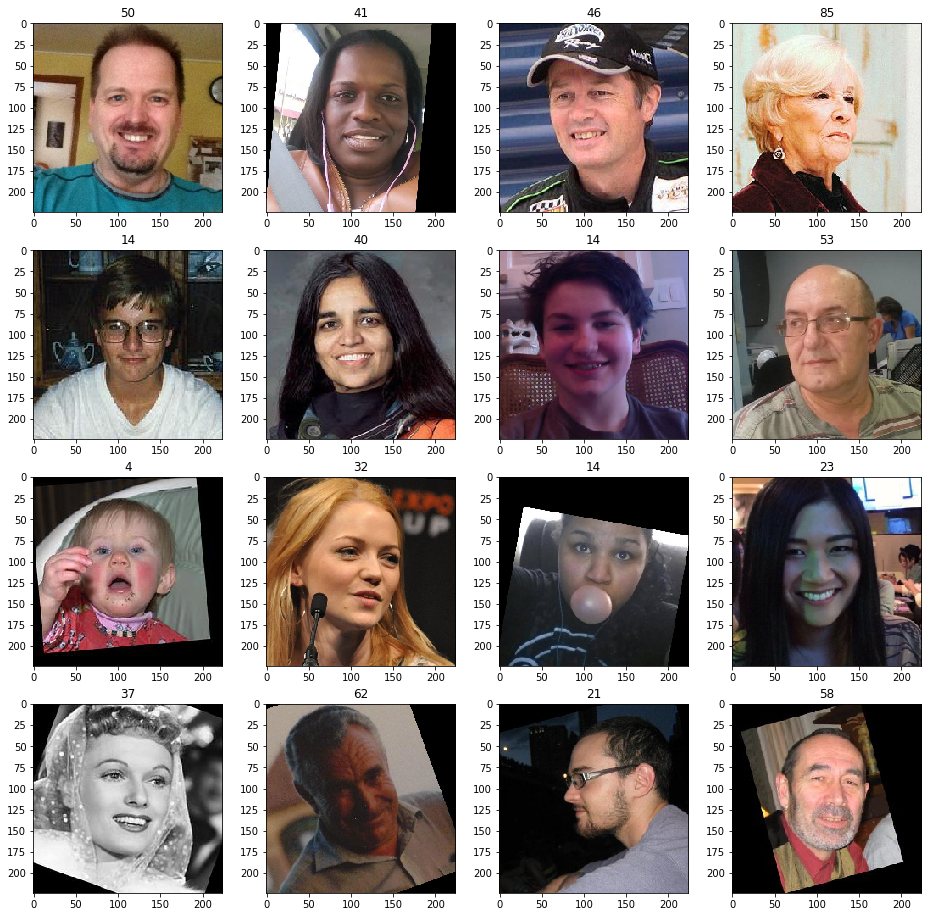

In [13]:
fig = plt.figure(figsize = (16, 16))
for i in range(array.shape[0]):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(array[i])
    plt.title(target[i])

<div class = "alert alert-info">
    <b>
        Выборка достаточно большая - дополнительная аугментация при работе с будущей моделью скорее всего не потребуется. Да, и правда есть такие выбросы, думал написать но как-то решил что не стоит. Учитывая что у меня нет информации, что это вообще за датасет с фотографиями, сложно сказать чем могут быть обусловлены такие выбросы, больше всего похоже на округление, но непонятно в связи с чем. По крайней мере, минут за 5 достойных объяснений в голову особо не пришло, так что буду рад узнать какие тут могли бы быть варианты. Насчет фотографий - качество на них в основном среднее, небольшая часть с качеством выше, и небольшая с качеством ниже, из 16 выбранных только одна черно-белая. Некоторые фотографии скошены, но не сильно. На одной вотографии лицо в профиль(боком), на одной в полупрофиль, все остальные в анфас(лицом в камеру). При необходимости аугментаций я бы предложил затемнение и засветление, небольшую смену контрастов - так еще и побеждается вопрос с разным цветом кожи и ее оттенками, и возможно горизонтальное отзеркаливание, думаю этого в сумме точно будет достаточно
    </b>
    </div>

## Обучение модели

```python

datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255) 
 
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_gen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory=path + 'final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),
    batch_size=16,
    class_mode='raw',
    subset='training',
    seed=12345)
 
    return train_gen_flow 
 
 
 
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_gen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory=path + 'final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),
    batch_size=16,
    class_mode='raw',
    subset='validation',
    seed=12345)
 
    return test_gen_flow
 
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    backbone.trainable = True
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
 
    optimizer = Adam(lr=0.0001)
 
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
 
    return model
 
def train_model(model, train_data, test_data, batch_size=None, epochs=25,
                steps_per_epoch=None, validation_steps=None): 
    model.fit(train_data,
                  validation_data=test_data,
                  batch_size=batch_size, epochs=epochs,
                  steps_per_epoch=steps_per_epoch,
                  validation_steps=validation_steps, 
                  verbose=2)
 
    return model
```

```
Train for 356 steps, validate for 119 steps
Epoch 1/25
2021-04-14 08:55:22.843079: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-04-14 08:55:26.744769: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 119s - loss: 217.1832 - mae: 10.7231 - val_loss: 551.7612 - val_mae: 18.3962
Epoch 2/25
356/356 - 38s - loss: 68.1349 - mae: 6.3381 - val_loss: 215.7900 - val_mae: 11.0198
Epoch 3/25
356/356 - 38s - loss: 36.1327 - mae: 4.6473 - val_loss: 77.3305 - val_mae: 6.6180
Epoch 4/25
356/356 - 39s - loss: 21.5044 - mae: 3.5894 - val_loss: 82.3514 - val_mae: 7.0351
Epoch 5/25
356/356 - 38s - loss: 14.2015 - mae: 2.9107 - val_loss: 73.8948 - val_mae: 6.5934
Epoch 6/25
356/356 - 39s - loss: 12.7213 - mae: 2.7421 - val_loss: 72.9710 - val_mae: 6.4223
Epoch 7/25
356/356 - 39s - loss: 13.1602 - mae: 2.7528 - val_loss: 76.4063 - val_mae: 6.6954
Epoch 8/25
356/356 - 38s - loss: 11.8496 - mae: 2.6169 - val_loss: 69.1638 - val_mae: 6.3142
Epoch 9/25
356/356 - 39s - loss: 10.4742 - mae: 2.4583 - val_loss: 73.1342 - val_mae: 6.5807
Epoch 10/25
356/356 - 38s - loss: 9.9453 - mae: 2.3702 - val_loss: 89.4495 - val_mae: 6.9966
Epoch 11/25
356/356 - 39s - loss: 9.4093 - mae: 2.3184 - val_loss: 78.6532 - val_mae: 6.7520
Epoch 12/25
356/356 - 39s - loss: 10.2542 - mae: 2.4019 - val_loss: 68.1878 - val_mae: 6.2545
Epoch 13/25
356/356 - 38s - loss: 9.5944 - mae: 2.3378 - val_loss: 69.8650 - val_mae: 6.3604
Epoch 14/25
356/356 - 39s - loss: 8.3705 - mae: 2.1782 - val_loss: 73.0507 - val_mae: 6.6654
Epoch 15/25
356/356 - 39s - loss: 7.7310 - mae: 2.1157 - val_loss: 73.0490 - val_mae: 6.5862
Epoch 16/25
356/356 - 39s - loss: 7.0806 - mae: 1.9966 - val_loss: 68.3734 - val_mae: 6.4049
Epoch 17/25
356/356 - 39s - loss: 7.2126 - mae: 2.0244 - val_loss: 68.2959 - val_mae: 6.3271
Epoch 18/25
356/356 - 39s - loss: 6.9304 - mae: 1.9952 - val_loss: 71.4834 - val_mae: 6.2819
Epoch 19/25
356/356 - 38s - loss: 6.5899 - mae: 1.9513 - val_loss: 70.4490 - val_mae: 6.4669
Epoch 20/25
356/356 - 39s - loss: 6.3922 - mae: 1.9298 - val_loss: 67.6649 - val_mae: 6.2447
Epoch 21/25
356/356 - 38s - loss: 6.8231 - mae: 1.9752 - val_loss: 69.7255 - val_mae: 6.3111
Epoch 22/25
356/356 - 39s - loss: 7.5655 - mae: 2.0588 - val_loss: 67.4911 - val_mae: 6.2670
Epoch 23/25
356/356 - 39s - loss: 7.0133 - mae: 1.9822 - val_loss: 78.9039 - val_mae: 6.5964
Epoch 24/25
356/356 - 38s - loss: 5.4258 - mae: 1.7579 - val_loss: 64.9082 - val_mae: 5.9324
Epoch 25/25
356/356 - 38s - loss: 4.3737 - mae: 1.5779 - val_loss: 72.6373 - val_mae: 6.3028
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 72.6373 - mae: 6.3028
Test MAE: 6.3028
```

## Анализ обученной модели

#### На деле видно, что уже после 3 эпох результат не сильно улучшился, а в основном скакал взад-вперед. По итогу получили модель, которая довольно точно вычисляет возраст по фотографии. Итоговае качество модели по метрике MAE - 6.3. По значениям метрики видно что модель, по ощущениям, близка к переобучению, так что я бы в идеале использовал даже меньше эпох, ну или в крайнем случае не сильно больше. Хотя, вполне возможно что использовав пару приемов аугментации до переобучения было бы еще далеко. Парметры использовались довольно базовые, просто модель ResNet50 без особых хитростей